In [25]:
import pandas as pd
import geopandas as gpd
import os
import folium
import matplotlib.pyplot as plt

In [26]:
Barcelona_map= folium.Map(
    location=[41.390205, 2.154007],
    tiles='cartodbpositron',
    zoom_start=12,
)
Barcelona_map

In [28]:
bike_stations=pd.read_csv('bike_stations.csv')
bike_stations.head()

,id,name,lat,lon,nearby_stations
0,1,"Gran Via Corts Catalanes, 760",41.397952,2.180042,"24,369,387,424"
1,10,"Pl. Comercial, 11",41.385531,2.183527,"7,14,115,405"
2,100,"Tarragona, 159",41.379135,2.144090,"97,98,99,384"
3,101,"Av. Pau Casals, 1",41.392988,2.143562,"74,102,319,366"
4,102,"Av. Pau Casals, 3",41.393093,2.143365,"74,102,319,366"


In [29]:
bike_stations.shape

(419, 5)

In [30]:
bike_stations.isna().sum()

id                 0
name               0
lat                0
lon                0
nearby_stations    0
dtype: int64

In [31]:
bike_stations.apply(lambda row:folium.CircleMarker([row["lat"], row["lon"]]).add_to(Barcelona_map), axis=1)
Barcelona_map

In [36]:
bike_path=pd.read_csv('bike_path.csv')
bike_path.head()

,Tram,Descripció,Coordenades
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),"2.11203535639414,41.3841912394771,2.1015028628..."
1,2,Diagonal (Doctor Marañón a Ronda de Dalt),"2.111944376806616,41.38446666680338,2.10159408..."
2,3,Diagonal (Doctor Marañón a Pl. Pius XII),"2.112093343037027,41.38422850920645,2.12264979..."
3,4,Diagonal (Pl. Pius XII a Doctor Marañón),"2.122592049318304,41.38719094189204,2.11196902..."
4,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina),"2.122657659295115,41.38694195794678,2.12755961..."


In [37]:
bike_path.shape

(491, 3)

In [38]:
bike_path['Coordenades'].isna().sum()

0

In [39]:
expanded_coords = bike_path["Coordenades"].str.split(",", expand=True)
expanded_coords.head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,2.11203535639414,41.3841912394771,2.101502862881051,41.3816307921222,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2.111944376806616,41.38446666680338,2.101594089443895,41.38186790291103,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2.112093343037027,41.38422850920645,2.122649794166167,41.38692960796057,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2.122592049318304,41.38719094189204,2.111969021588291,41.38445704285778,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2.122657659295115,41.38694195794678,2.127559612359478,41.38817909013056,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [40]:
expanded_coords.shape

(491, 76)

In [41]:
len(expanded_coords.columns)

76

In [42]:
import typing as T
from itertools import zip_longest

In [43]:
!pip install shapely

In [44]:
sample = bike_path["Coordenades"].str.split(",")[0]
sample

['2.11203535639414',
 '41.3841912394771',
 '2.101502862881051',
 '41.3816307921222']

In [45]:
def reshape_line(line: T.List[str], chunksize: int, fillvalue: int) -> T.Iterable[T.Tuple[float]]:
  
    args = [iter(float(el) for el in line)] * chunksize
    return zip_longest(*args, fillvalue=fillvalue)

In [46]:
list(reshape_line(sample, chunksize=2, fillvalue=0))

[(2.11203535639414, 41.3841912394771), (2.101502862881051, 41.3816307921222)]

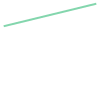

In [47]:
from shapely.geometry import LineString

sample_wkt = LineString(reshape_line(sample, 2, 0))
sample_wkt

In [48]:
def convert_line_to_wkt(line: str) -> LineString:
    splitted_line = line.split(",")
    reshaped_line = reshape_line(splitted_line, chunksize=2, fillvalue=None)
    return LineString(reshaped_line)

In [49]:
# let's process the whole column
coords_wkt = bike_path["Coordenades"].apply(lambda line: convert_line_to_wkt(line))

# access the __str__ of the first element
print(coords_wkt[1])

LINESTRING (2.111944376806616 41.38446666680338, 2.101594089443895 41.38186790291103)


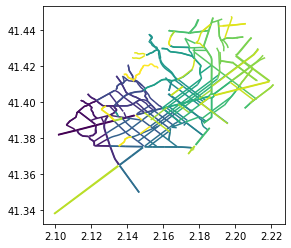

In [51]:
from geopandas import GeoDataFrame

crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(streets, crs=crs, geometry=coords_wkt)
ax = gdf.plot(cmap="viridis") 

In [52]:
barcelona_map = folium.Map([41.3947,2.1557], zoom_start=12.4, tiles='cartodbpositron')
folium.GeoJson(gdf).add_to(barcelona_map)
# plot map
barcelona_map